Italy house prices prediction.
Dataset https://www.kaggle.com/datasets/tommasoramella/italy-house-prices/data


In [242]:

path = "italy-house-prices"

print("Path to dataset files:", path)

Path to dataset files: italy-house-prices


In [243]:
import os
PATH = path+"/versions/8"
os.listdir(PATH)

['limits_IT_municipalities.geojson',
 'limits_IT_provinces.geojson',
 'limits_IT_regions.geojson',
 'rents_clean.csv',
 'rent_raw.csv',
 'sale_clean.csv',
 'sale_raw.csv']

In [244]:
import pandas as pd
import numpy as np
from deep_translator import GoogleTranslator
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
from pandas_geojson import read_geojson

In [245]:
df_rent_clean = pd.read_csv(PATH + "/rents_clean.csv")
df_rent_clean.head(3)

,regione,citta,quartiere,prezzo,datetime,posti auto,bagni per stanza,bagni,stanze,ultimo piano,...,giardino privato,impianto allarme,portiere,piscina,villa,intera proprieta,appartamento,attico,loft,mansarda
0,NaN,Milano,Centrale,1800.0,2023-07-03,1,0.333333,1.0,3.0,0,...,0,0,0,0,0,0,1,0,0,0
1,NaN,Torino,Santa Rita,450.0,2023-07-03,0,0.500000,1.0,2.0,1,...,0,0,0,0,0,0,1,0,0,0
2,NaN,Padova,Prato della Valle - Pontecorvo,3200.0,2023-07-03,1,NaN,3.0,NaN,0,...,0,0,0,0,0,0,1,0,0,0


DATA CLEANING

In [246]:
## translate columns in English
def translate(italian_input):
    return GoogleTranslator(source="it", target="en").translate(italian_input)

columns_translated = [translate(c) for c in df_rent_clean.columns]
columns_translated[12], columns_translated[-1] = "sea_view", "mansard"
columns_translated = [c.replace(" ", "_") for c in columns_translated]
df_rent_clean.columns = columns_translated
df_rent_clean.head(3)


,region,city,quarter,price,datetime,parking_spaces,Bathrooms_per_room,bathrooms,rooms,top_floor,...,private_garden,alarm_system,doorman,pool,villa,full_ownership,apartment,penthouse,loft,mansard
0,NaN,Milano,Centrale,1800.0,2023-07-03,1,0.333333,1.0,3.0,0,...,0,0,0,0,0,0,1,0,0,0
1,NaN,Torino,Santa Rita,450.0,2023-07-03,0,0.500000,1.0,2.0,1,...,0,0,0,0,0,0,1,0,0,0
2,NaN,Padova,Prato della Valle - Pontecorvo,3200.0,2023-07-03,1,NaN,3.0,NaN,0,...,0,0,0,0,0,0,1,0,0,0


12500000.0


Text(0.5, 1.0, 'Rent in €')

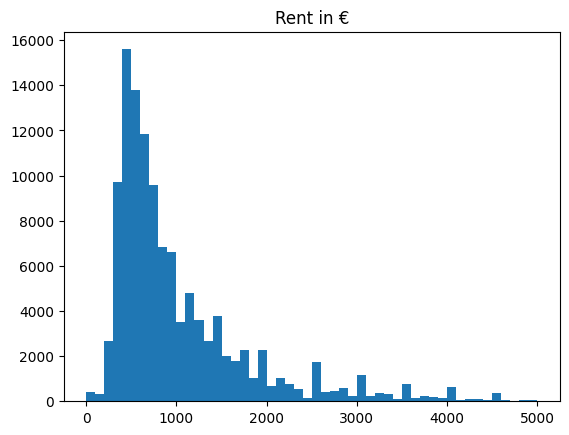

In [247]:
## drop outliers
print(df_rent_clean["price"].max())
df_rent_clean = df_rent_clean.loc[df_rent_clean["price"] < 5000]
plt.hist(df_rent_clean["price"], bins=50)
plt.title("Rent in €")

In [248]:
## clean datetime
import datetime
from datetime import date
today = np.datetime64(date.today())
full_calendar = pd.DataFrame(pd.date_range(start="2023-01-01", end=today), columns=["datetime"])

df_rent_clean["datetime"] = pd.to_datetime(df_rent_clean["datetime"])
df_rent_clean = df_rent_clean.loc[(df_rent_clean["datetime"] > "2023-01-01") & (df_rent_clean["datetime"] < today)]
df_rent_clean["month"] = df_rent_clean["datetime"].dt.to_period("M").dt.start_time
df_rent_clean["week"] = df_rent_clean["datetime"].dt.to_period("W").dt.start_time
df_rent_clean["week"]

0        2023-07-03
1        2023-07-03
2        2023-07-03
4        2023-05-29
5        2023-11-27
            ...    
126232   2023-07-24
126233   2023-07-24
126234   2023-07-24
126235   2023-07-24
126236   2023-07-24
Name: week, Length: 113226, dtype: datetime64[ns]

DATA EXPLORATION

In [249]:
df_rent_clean.region.value_counts().sort_values(ascending=False)

region
lombardia                23516
lazio                    18265
piemonte                 14967
emilia-romagna           12347
veneto                    7363
toscana                   7058
campania                  6381
liguria                   5569
sicilia                   5185
marche                    2380
puglia                    2372
umbria                    2368
abruzzo                   1617
trentino-alto-adige       1243
sardegna                   784
calabria                   675
basilicata                 250
friuli-venezia-giulia      248
valle-d-aosta              243
molise                     240
emilia-Romagna              66
trieste                     25
catanzaro                   21
genova                       7
palermo                      5
bari                         4
l-aquila                     3
napoli                       3
Liguria                      2
torino                       2
milano                       2
ancona                       2
v

Text(0.5, 1.0, 'Squared meters')

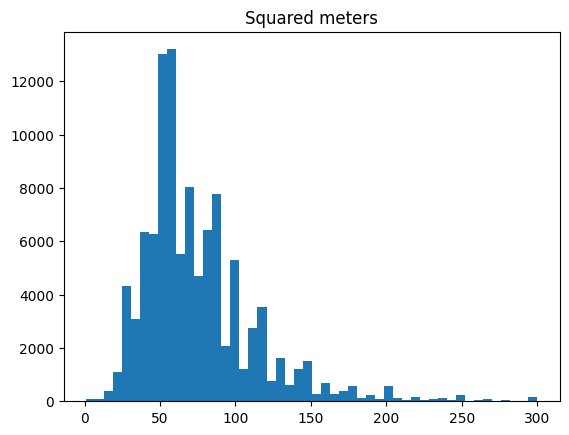

In [250]:
## sq. meters
plt.hist(df_rent_clean["surface"], bins=50)
plt.title("Squared meters")

In [251]:
## furnished
df_rent_clean["furnished"].value_counts(normalize=True)*100

furnished
1    72.502782
0    27.497218
Name: proportion, dtype: float64

{'Apartments': 103981, 'Villa': 4172, 'Attic': 2959, 'Loft': 397}


Text(0.5, 1.0, 'Flat type')

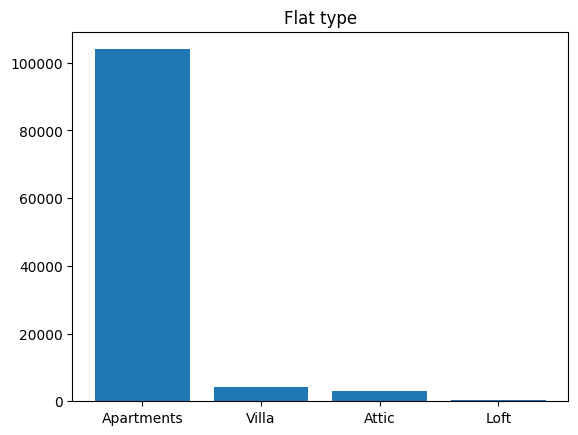

In [252]:
## type of building
types = {
    "Apartments": len(df_rent_clean.loc[df_rent_clean["apartment"] == 1]),
    "Villa": len(df_rent_clean.loc[df_rent_clean["villa"] == 1]),
    "Attic": len(df_rent_clean.loc[df_rent_clean["penthouse"] == 1]) + len(df_rent_clean.loc[df_rent_clean["mansard"] == 1]),
    "Loft": len(df_rent_clean.loc[df_rent_clean["loft"] == 1])
}
print(types)
plt.bar(types.keys(), types.values())
plt.title("Flat type")

GEOGRAPHICAL ANALYSIS

Text(0, 0.5, 'Region')

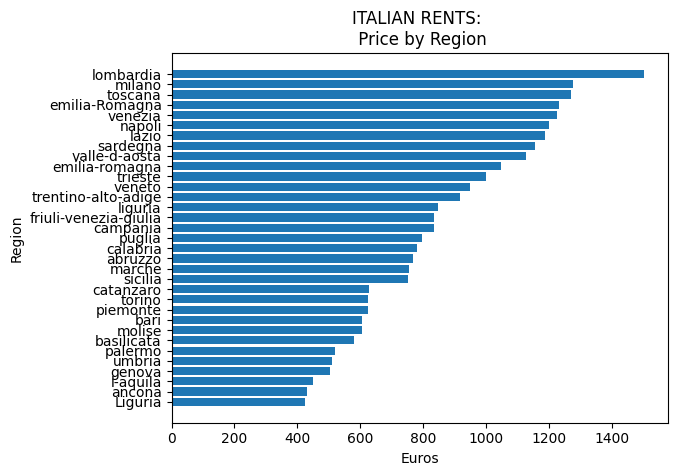

In [253]:
## price by region
price_by_region = df_rent_clean["price"].groupby(df_rent_clean["region"]).mean().sort_values(ascending=True)
fig1, ax = plt.subplots()
ax.barh(price_by_region.index, price_by_region)
ax.set_title(f"ITALIAN RENTS: \n Price by Region")
ax.set_xlabel("Euros")
ax.set_ylabel("Region")

In [254]:
# get centroids coordinates from geojson
def get_area_centroids(geo_file):
    coords = gpd.read_file(geo_file)
    # Convert to a projected CRS (e.g., EPSG:3857 or EPSG:3035)
    coords = coords.to_crs(epsg=3857)
    centroids = coords.geometry.centroid
    coords["geometry"] = centroids
    coords = coords.to_crs(epsg=4326)
    lon = coords.geometry.x
    lat = coords.geometry.y
    coords["lat"], coords["lon"] = lat, lon
    return coords
    

In [255]:
regions_json = "italy-house-prices/versions/8/limits_IT_regions.geojson"
provs_json = "italy-house-prices/versions/8/limits_IT_provinces.geojson"
municipalities_json = "italy-house-prices/versions/8/limits_IT_municipalities.geojson"

region_coords = get_area_centroids(regions_json)
provinces_coords = get_area_centroids(provs_json)
municipalities_coords = get_area_centroids(municipalities_json)



In [256]:
# plot prices by area
def map_prices_plot(prices_by_area, type_of_area):
    fig = px.scatter_map(
        prices_by_area, lat="lat", lon="lon",
        hover_name=type_of_area,
        hover_data=["price"],
        color="price",
        color_continuous_scale="turbo",
        range_color=(0, 2000),
        size="price",
        zoom=5,
        center=dict(lat=41.8719, lon=12.5674),
        opacity=0.5,
        labels={"price": "Price in €"},
        height=700, width=700
    )

    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":5, "t":0, "l":0, "b":0})
    fig.show()




In [257]:
## group by region
df_rent_clean["region"] = df_rent_clean["region"].str.title()
prices_by_region = df_rent_clean.merge(region_coords, left_on="region", right_on="reg_name", how="left")
prices_by_region = prices_by_region.groupby(["region", "lat", "lon"]).agg({"price": "mean"}).reset_index().sort_values(by=["price"], ascending=True)
prices_by_region = prices_by_region[["region", "lat", "lon", "price"]]
prices_by_region = prices_by_region.dropna(subset=["lat", "lon"])

map_prices_plot(prices_by_region, "region")


In [258]:
## group by province
prices_by_province = df_rent_clean.merge(provinces_coords, left_on="city", right_on="prov_name", how="left")
prices_by_province = prices_by_province.groupby(["city", "lat", "lon"]).agg({"price": "mean"}).reset_index().sort_values(by=["price"], ascending=True)
prices_by_province = prices_by_province[["city", "lat", "lon", "price"]]
prices_by_province = prices_by_province.dropna(subset=["lat", "lon"])

map_prices_plot(prices_by_province, "city")

In [259]:
# group by municipality
prices_by_municipalities = df_rent_clean.merge(municipalities_coords, left_on='city', right_on='name', how='left')
prices_by_municipalities = prices_by_municipalities.groupby(["city", "lat", "lon"]).agg({'price': 'mean'}).reset_index().sort_values(by=['price'], ascending=True)
prices_by_municipalities = prices_by_municipalities[['city', 'lat', 'lon', 'price']]
prices_by_municipalities = prices_by_municipalities.dropna(subset=['lat', 'lon'])

map_prices_plot(prices_by_municipalities, "city")

TIME SERIES

<Axes: xlabel='week', ylabel='price'>

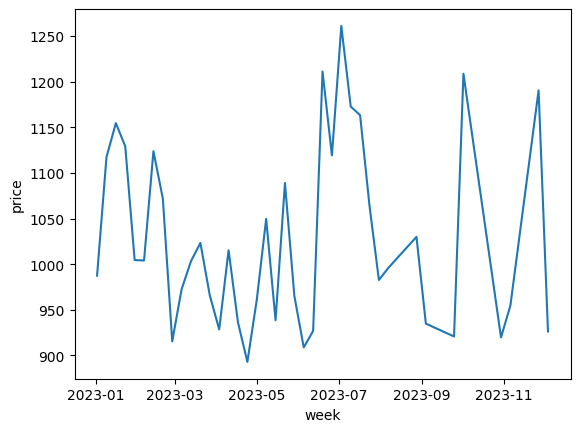

In [260]:
# mean price in Italy
mean_price_italy = df_rent_clean.groupby(["week"])["price"].mean().reset_index()
sns.lineplot(mean_price_italy, x="week", y="price")


<Axes: xlabel='week', ylabel='price'>

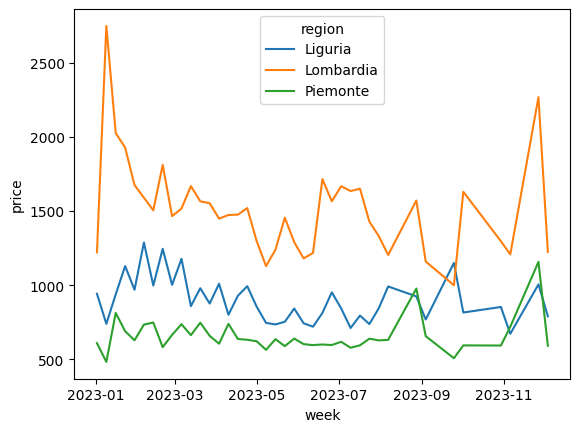

In [261]:
regions = ["Liguria", "Lombardia", "Piemonte"]
df_regions = df_rent_clean.loc[df_rent_clean["region"].isin(regions)]
mean_price_region = df_regions.groupby(["week", "region"])["price"].mean().reset_index()
sns.lineplot(mean_price_region, x="week", y="price", hue="region")


In [262]:
import statsmodels.api as sm
## define functions
def LinearRegression(y, x):
    x = sm.add_constant(x)
    ols = sm.OLS(y, x).fit()
    ols_table = ols.summary()
    return ols_table

def TableResults(ols_table, labels):
    """Create a table with the results of the OLS regression
    ols_table: the output of the LinearRegression function
    labels: the labels of the variables
    """
    ## format the ols table
    table = pd.DataFrame(ols_table.tables[1])
    list_col = ['ind_var', 'coef', 'std_err', 't_val', 'p_val', 'low_ci', 'high_ci']
    for num in range(0,len(table.columns)):
        table.rename(columns={table.columns[num]: f"{list_col[num]}" }, inplace = True)
    table = table.iloc[2:,:]
    #ols = sm.OLS(y, x).fit()
    #table['obs'] = ols.nobs
    table.rename(columns={"P>|t|": "p_val", "[0.025": "low_ci", "0.975]": "high_ci"}, inplace=True)
    table = table.set_index(table.columns[0])
    table = round(table, 3)
    table_results = table.applymap(str).applymap(float)
    table_results.index = labels
    return table_results

import matplotlib.pyplot as plt

def Plot_ols_coefficients_and_CI(table):
    """Plot the OLS results with the 95% confidence intervals"""
    ## prepare the data
    n_coeff = len(table.index)
    print(table.index)
    table = table.iloc[0:n_coeff, :]
    lower = table['low_ci']
    upper = table['high_ci']
    table['variables'] = table.index.values
    n = len(table)
    l = range(0, n)
    labels = [0] * n
    names = table['variables']

    ##plot
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.plot((lower,upper), (l, l), 'ro-', color='blue', linewidth=2, markersize=2)
    plt.scatter(x=table.coef, y=range(0,len(table)))
    ax.tick_params(axis='both', which='both')
    plt.yticks(range(0, n), names)
    plt.plot(labels, l, '--', color='red', linewidth=2, markersize=2)
    ax.set_ylabel('Coefficients', fontsize=10)
    plt.scatter(lower-.002, l, marker='|', color='blue')
    plt.scatter(upper+.002, l, marker='|', color='blue')
    ax.set_facecolor('white')
    plt.title('PRICE PREDICTORS \nOLS coefficients - 95% Confidence Intervals', fontsize=15)

def plot_coefficient_bars(table_results):
    bars = table_results['coef']
    bars = pd.DataFrame(bars)
    bars['value'] = np.where(bars['coef']>0, 1, 0)
    bars['coef'] = abs(bars['coef'])
    bars = bars.sort_values(by="coef")
    bars['colors'] = np.where(bars['value']==0, "green", "red")

    fig = plt.figure(figsize = (10, 10))
    plt.barh(bars.index, bars['coef'], color=bars['colors'])
    plt.xlabel("Value")
    # y-axis label
    plt.ylabel("Coefficients")
    # Title of the figure
    plt.title("Ols coefficients: Predictors of Price")
    plt.legend(['Negative predictors', 'Positive predicgors'], loc='lower right')
    plt.show()
    plt.savefig("bar_plots.jpeg", bbox_inches='tight')

In [263]:
df_rent_clean['energy_class'].value_counts()
df = df_rent_clean.loc[df_rent_clean['energy_class']!=","]
df_rent_clean.columns

Index(['region', 'city', 'quarter', 'price', 'datetime', 'parking_spaces',
       'Bathrooms_per_room', 'bathrooms', 'rooms', 'top_floor', 'state',
       'energy_class', 'sea_view', 'central_heating', 'surface', 'furnished',
       'balcony', 'TV_system', 'external_exposure', 'optical_fiber',
       'electric_gate', 'cellar', 'common_garden', 'private_garden',
       'alarm_system', 'doorman', 'pool', 'villa', 'full_ownership',
       'apartment', 'penthouse', 'loft', 'mansard', 'month', 'week'],
      dtype='object')

In [264]:
columns = ['price', 'month', 'parking_spaces', 'Bathrooms_per_room', 'bathrooms', 'rooms', 
          'top_floor', 'state', 'energy_class', 'sea_view', 'central_heating', 'surface', 'furnished', 
          'balcony', 'cellar', 'common_garden', 'private_garden', 'pool', 'furnished', 'apartment']

df_rent_clean = df_rent_clean[columns]

In [265]:
col_dummies = ['region', 'month', 'energy_rating']

#df_rent_clean = pd.get_dummies(df_rent_clean, columns=['region'])
df_rent_clean = pd.get_dummies(df_rent_clean, columns=['month'])
df_rent_clean = pd.get_dummies(df_rent_clean, columns=['energy_class'])
df_rent_clean = pd.get_dummies(df_rent_clean, columns=['state'])

In [266]:
df_rent_clean = df_rent_clean.dropna()

# Extract X (independent vars) and y (target var)
X = df_rent_clean.drop(['price'], axis=1)
y = df_rent_clean['price']

# Convert Boolean to Integer (True -> 1, False -> 0)
X = X.astype(float)

# Ensure all columns in X are numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Replace Inf with NaN and drop NaN rows
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.replace([np.inf, -np.inf], np.nan).dropna()

col_names = X.columns
# Convert to NumPy arrays
X = X.values
y = y.values

# Check if the dimensions match
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)




Shape of X: (86448, 40)
Shape of y: (86448,)


In [267]:
print("X dtype:", X.dtype)
print("y dtype:", y.dtype)

X dtype: float64
y dtype: float64


In [268]:

ols_table = LinearRegression(y, X)
table_results = TableResults(ols_table, col_names)
table_results

C:\Users\franc\AppData\Local\Temp\ipykernel_19080\1699274897.py:25: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,coef,std_err,t_val,p_val,low_ci,high_ci
parking_spaces,-202.7436,4.712,-43.024,0.000,-211.980,-193.507
Bathrooms_per_room,-450.5192,16.571,-27.187,0.000,-482.998,-418.040
bathrooms,410.5017,8.457,48.541,0.000,393.926,427.077
rooms,-108.9975,4.812,-22.652,0.000,-118.429,-99.566
top_floor,-48.7876,5.741,-8.498,0.000,-60.041,-37.535
sea_view,253.3389,17.685,14.325,0.000,218.677,288.001
central_heating,169.0004,4.933,34.261,0.000,159.332,178.669
surface,6.6610,0.106,62.877,0.000,6.453,6.869
furnished,63.2439,2.543,24.867,0.000,58.259,68.229
balcony,-161.6230,4.468,-36.175,0.000,-170.380,-152.866


C:\Users\franc\AppData\Local\Temp\ipykernel_19080\1699274897.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\franc\AppData\Local\Temp\ipykernel_19080\1699274897.py:47: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.



Index(['parking_spaces', 'Bathrooms_per_room', 'bathrooms', 'rooms',
       'top_floor', 'sea_view', 'central_heating', 'surface', 'furnished',
       'balcony', 'cellar', 'common_garden', 'private_garden', 'pool',
       'furnished', 'apartment', 'month_2023-01-01 00:00:00',
       'month_2023-02-01 00:00:00', 'month_2023-03-01 00:00:00',
       'month_2023-04-01 00:00:00', 'month_2023-05-01 00:00:00',
       'month_2023-06-01 00:00:00', 'month_2023-07-01 00:00:00',
       'month_2023-08-01 00:00:00', 'month_2023-09-01 00:00:00',
       'month_2023-10-01 00:00:00', 'month_2023-11-01 00:00:00',
       'month_2023-12-01 00:00:00', 'energy_class_,', 'energy_class_A',
       'energy_class_B', 'energy_class_C', 'energy_class_D', 'energy_class_E',
       'energy_class_F', 'energy_class_G', 'state_buono / abitabile',
       'state_da ristrutturare', 'state_nuovo / in costruzione',
       'state_ottimo / ristrutturato'],
      dtype='object')


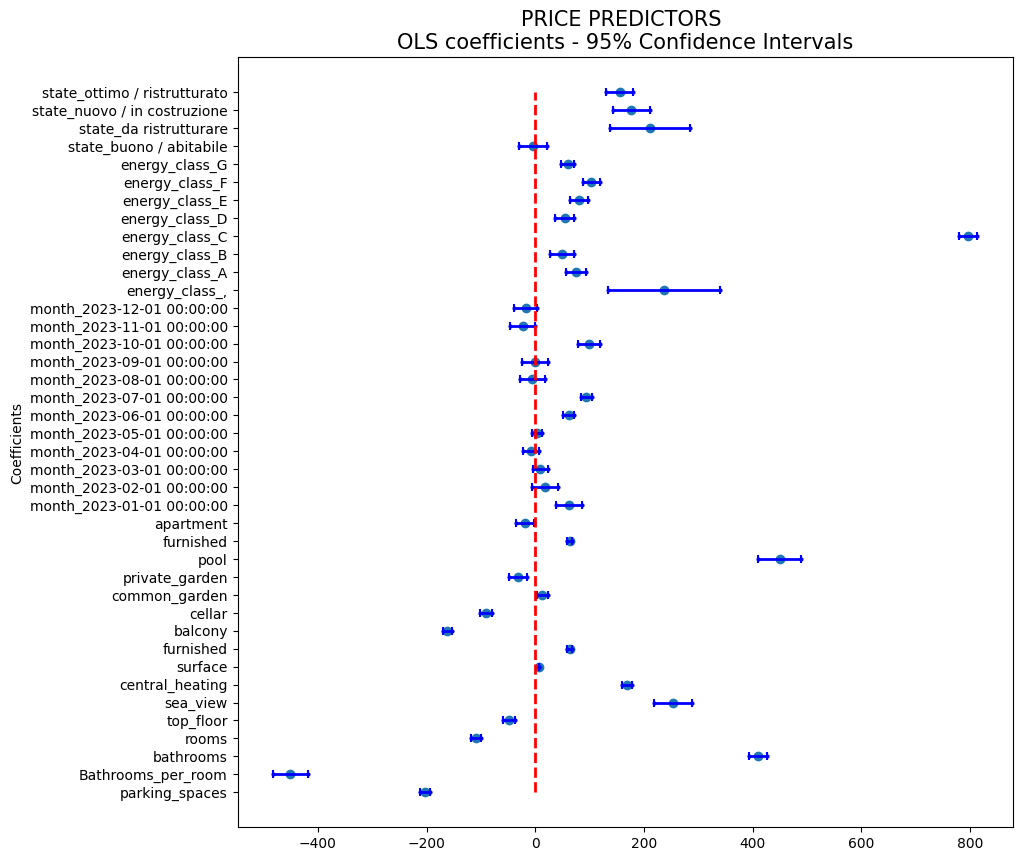

In [269]:
Plot_ols_coefficients_and_CI(table_results)

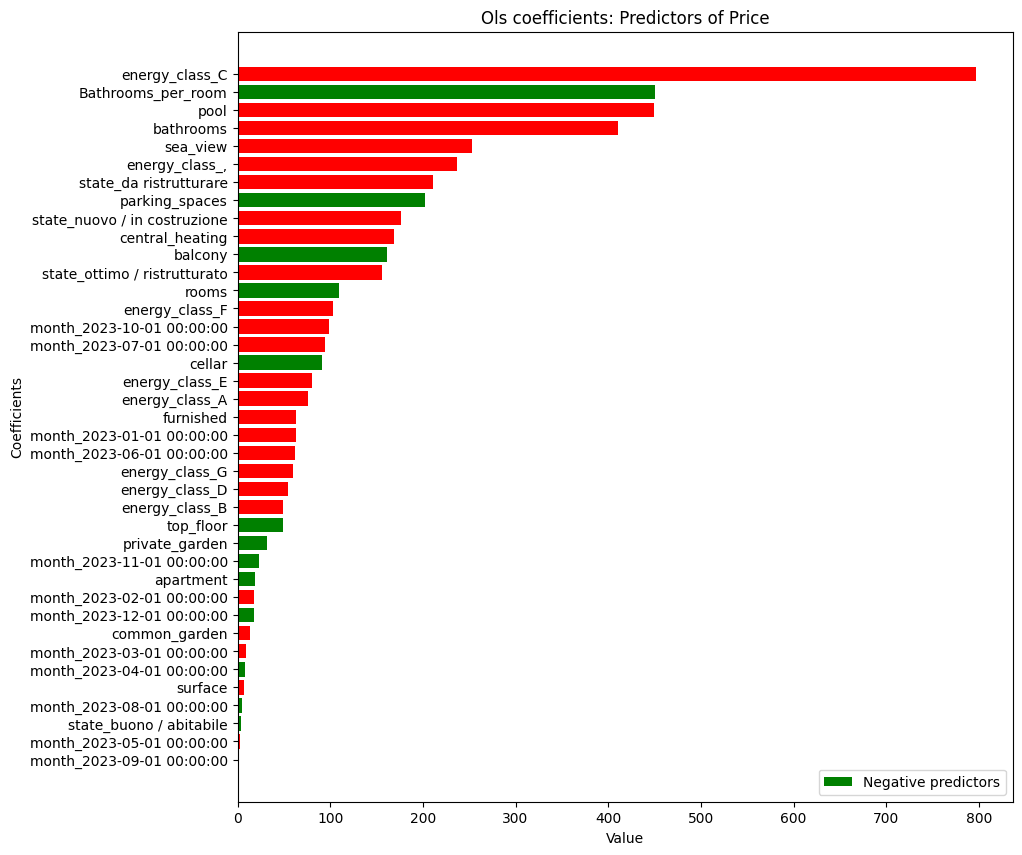

<Figure size 640x480 with 0 Axes>

In [270]:
plot_coefficient_bars(table_results)